# XGBoost Model - Energy Cost Prediction with Time Series

### 1. Importing needed libraries

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

### 2. Reading data and set index

- the datetime column of our data is put as the index, because it is consistent
- changing the index from type 'object' to type 'datetime'

In [248]:
df = pd.read_csv(
    "C:/Users/zawad/OneDrive/Desktop/team-6-energy-costs/data/prepared/df_energy_climate_2020.csv")
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

- visualizing the dataframe

<AxesSubplot:xlabel='datetime'>

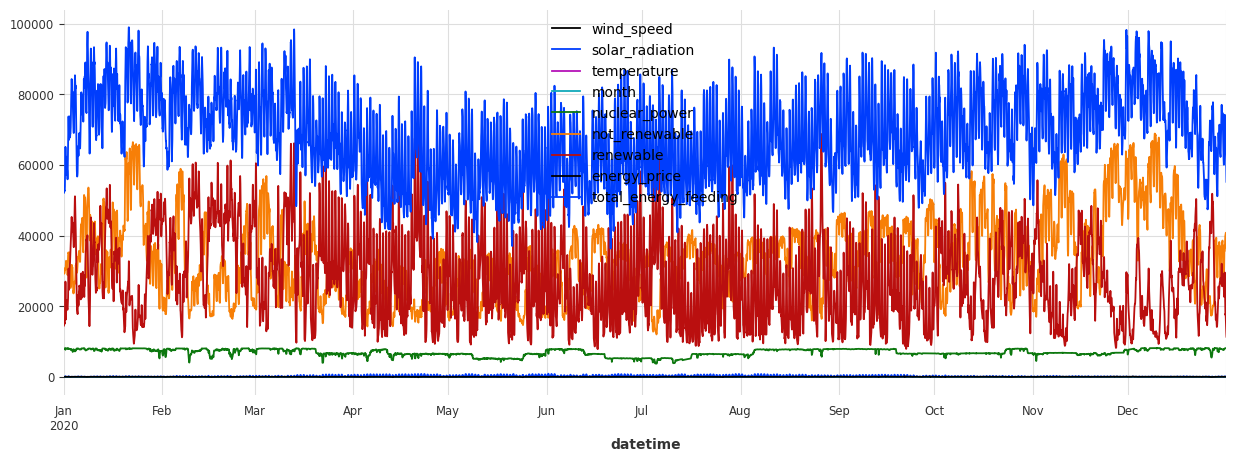

In [178]:
color_pal = sns.color_palette()
df.plot( figsize=(15, 5), color = color_pal)

### outlier removal

<AxesSubplot:ylabel='Frequency'>

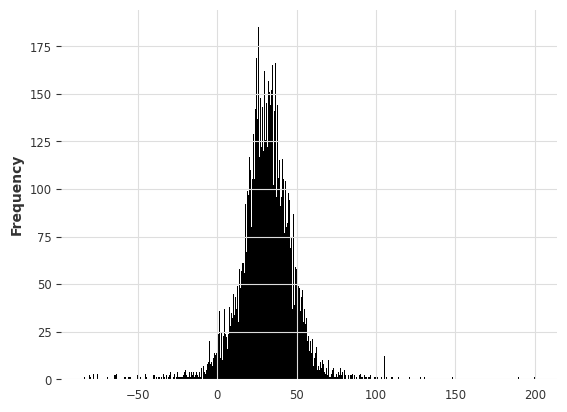

In [250]:
df['energy_price'].plot(kind='hist', bins=500)

In [253]:
df['energy_price'].query('energy_price < -50').plot()
#df = df.query('energy_price > 150').copy()

AttributeError: 'Series' object has no attribute 'query'

In [251]:
df.head()

,wind_speed,solar_radiation,temperature,date,day_of_week,time,month,nuclear_power,not_renewable,renewable,energy_price,total_energy_feeding
datetime,,,,,,,,,,,,
2020-01-01 00:00:00,2.4,0,-0.1,2020-01-01,Wednesday,00:00:00,1,8088.21750,29512.74850,14541.30200,38.60,52142.26800
2020-01-01 01:00:00,2.4,0,-0.5,2020-01-01,Wednesday,01:00:00,1,8081.15875,29178.66275,14949.45575,36.55,52209.27725
2020-01-01 02:00:00,2.5,0,-0.7,2020-01-01,Wednesday,02:00:00,1,8071.44750,29414.36225,15077.92500,32.32,52563.73475
2020-01-01 03:00:00,2.4,0,-1.0,2020-01-01,Wednesday,03:00:00,1,8072.27750,29365.12575,15307.22725,30.85,52744.63050
2020-01-01 04:00:00,2.4,0,-1.2,2020-01-01,Wednesday,04:00:00,1,8068.91550,29436.37500,15320.25825,30.14,52825.54875


### 3. Time Series Cross Validation

- we are using cross validation for our model to test the ability of it to predict new data in k-Folds we choose

In [179]:
#n_splits = the model will do 5 folds of cross validation
#test_size = as we have an hourly dataset and we want to predict one week so we set the test_size = 168 (hours in one week)

tss = TimeSeriesSplit(n_splits=5, test_size=168)
df = df.sort_index()

- visualizing the folds of the model for the column 'energy_price' to see how each fold works

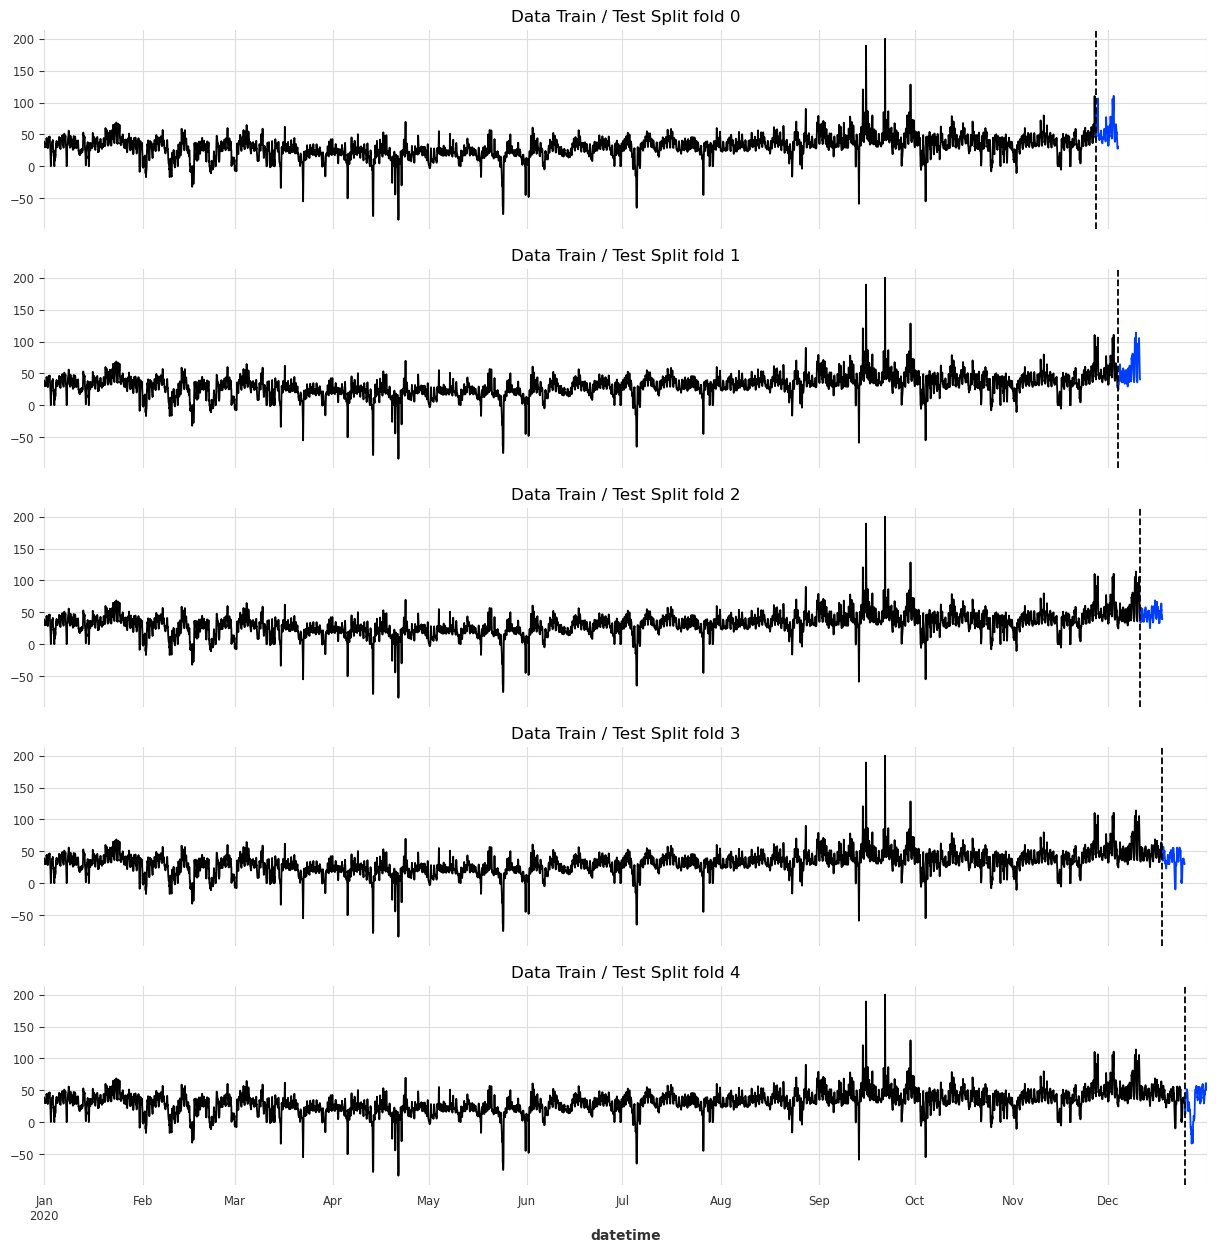

In [180]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['energy_price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train / Test Split fold {fold}')
    test['energy_price'].plot(ax=axs[fold], label='Testing Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

### 4. Feature creation - Future Covariates

- creating features for the TimeSeries to add to dataframe as future covariates for model.fit

In [181]:
def create_features(df):
    '''
    create time series features based on time series index
    '''
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

df = create_features(df)

### 6. Lag Features - Past Covariates

- using the value from (x) hours ago as the value is unknown on the day we want to predict
- we are going to try out three different (x) hours ago to fit our model: 168 (week), 24 (day) and 1 (hour)

In [185]:
def add_lags_week(df):
    '''
    new columns for 168 hours (one week) ago
    '''
    target_map = df['energy_price'].to_dict()
    df['week_energy_price']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['week_wind_speed']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['week_solar_radiation']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['week_temperature']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['week_nuclear_power']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['week_not_renewable']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['week_renewable']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    return df

In [186]:
def add_lags_day(df):
    '''
    new columns for 24 hours ago
    '''
    target_map = df['energy_price'].to_dict()
    df['day_energy_price']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['day_wind_speed']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['day_solar_radiation']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['day_temperature']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['day_nuclear_power']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['day_not_renewable']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['day_renewable']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    return df

In [187]:
def add_lags_hour(df):
    '''
    new columns for 1 hour ago
    '''
    target_map = df['energy_price'].to_dict()
    df['hour_energy_price']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['hour_wind_speed']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['hour_solar_radiation']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['hour_temperature']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['hour_nuclear_power']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['hour_not_renewable']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['hour_renewable']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    return df

- running our DataFrame through the functions to add features

In [188]:
df = add_lags_week(df)
df = add_lags_day(df)
df = add_lags_hour(df)
df.head(3)

,wind_speed,solar_radiation,temperature,date,day_of_week,time,month,nuclear_power,not_renewable,renewable,...,day_nuclear_power,day_not_renewable,day_renewable,hour_energy_price,hour_wind_speed,hour_solar_radiation,hour_temperature,hour_nuclear_power,hour_not_renewable,hour_renewable
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2.4,0,-0.1,2020-01-01,Wednesday,00:00:00,1,8088.21750,29512.74850,14541.30200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,2.4,0,-0.5,2020-01-01,Wednesday,01:00:00,1,8081.15875,29178.66275,14949.45575,...,NaN,NaN,NaN,38.60,2.4,0.0,-0.1,8088.21750,29512.74850,14541.30200
2020-01-01 02:00:00,2.5,0,-0.7,2020-01-01,Wednesday,02:00:00,1,8071.44750,29414.36225,15077.92500,...,NaN,NaN,NaN,36.55,2.4,0.0,-0.5,8081.15875,29178.66275,14949.45575


### 6. Train model using cross validation

### - training with weekly past covariates

In [189]:
fold = 0 

# creating lists of the root_mean_squared_error, the prediction and the mape to evaluate the scores later
preds_week = []
rmse_week = []
mape_week = []

# splitting our dataset into train and test data
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #adding the future features to our train and test data
    train = create_features(train)
    test = create_features(test)

    # creating a list for weekly past covariates and future covariates as well as our target data
    FEATURES_WEEK = ['hour', 'dayofweek','month', 'week_wind_speed', 'week_solar_radiation', 
                     'week_nuclear_power', 'week_not_renewable', 'week_renewable']
    
    TARGET = ['energy_price']

    # creating train and test data based on splitting our df and adding the independent (Features) and dependent (Target) values
    X_train = train[FEATURES_WEEK]
    y_train = train[TARGET]

    X_test = test[FEATURES_WEEK]
    y_test = test[TARGET]
    

    # creating the model
    # base_score = default value, initial prediction score of the model
    # booster = default value, type of boosting algorithm to use
    # n_estimators = how many trees the model is going to build
    # early_stopping_rounds = if model gets worse it will stop after 50 rounds
    # objective = loss function to be optimized during training
    # max_depth = maximum depth of each decision tree in the ensemble
    #learning_rate = shrinkage factor applied to each update of the model during training
    reg_week = xgb.XGBRegressor(base_score = 0.5, 
                                booster= 'gbtree',
                                n_estimators=1000, 
                                early_stopping_rounds=50, 
                                objective = 'reg:linear',
                                max_depth = 3,
                                learning_rate=0.01)

    # fitting the model
    reg_week.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100
        )
    
    # predicting and adding to lists
    y_pred = reg_week.predict(X_test)
    preds_week.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_week.append(score)
    predictions=y_pred.reshape(168,1)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    mape_week.append(mape)

[21:46:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.63435	validation_1-rmse:56.70383
[100]	validation_0-rmse:16.72602	validation_1-rmse:34.66070
[200]	validation_0-rmse:12.41959	validation_1-rmse:27.05763
[300]	validation_0-rmse:11.18127	validation_1-rmse:23.97756
[400]	validation_0-rmse:10.68107	validation_1-rmse:22.70210
[500]	validation_0-rmse:10.37430	validation_1-rmse:22.06076
[600]	validation_0-rmse:10.15510	validation_1-rmse:21.88350
[700]	validation_0-rmse:9.97786	validation_1-rmse:21.64575
[800]	validation_0-rmse:9.80322	validation_1-rmse:21.19702
[900]	validation_0-rmse:9.68564	validation_1-rmse:21.02294
[999]	validation_0-rmse:9.56859	validation_1-rmse:20.86535


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[21:46:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.30430	validation_1-rmse:57.74277
[100]	validation_0-rmse:17.06895	validation_1-rmse:34.32452
[200]	validation_0-rmse:12.75339	validation_1-rmse:24.64622
[300]	validation_0-rmse:11.54123	validation_1-rmse:21.50338
[400]	validation_0-rmse:10.98837	validation_1-rmse:19.89736
[500]	validation_0-rmse:10.67066	validation_1-rmse:18.91755
[600]	validation_0-rmse:10.44179	validation_1-rmse:18.67199
[628]	validation_0-rmse:10.37241	validation_1-rmse:18.70224
[21:46:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.97139	validation_1-rmse:46.05652


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:17.37573	validation_1-rmse:17.05546
[200]	validation_0-rmse:12.93895	validation_1-rmse:6.21775
[272]	validation_0-rmse:11.89766	validation_1-rmse:7.35009
[21:46:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.25229	validation_1-rmse:37.48816


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:17.42122	validation_1-rmse:15.02097
[200]	validation_0-rmse:12.92906	validation_1-rmse:12.59687
[226]	validation_0-rmse:12.47069	validation_1-rmse:12.92629
[21:46:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.31983	validation_1-rmse:38.95343


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:17.45796	validation_1-rmse:24.86129
[200]	validation_0-rmse:12.96521	validation_1-rmse:22.32406
[300]	validation_0-rmse:11.71427	validation_1-rmse:21.70383
[400]	validation_0-rmse:11.20014	validation_1-rmse:21.47217
[500]	validation_0-rmse:10.86790	validation_1-rmse:21.12803
[600]	validation_0-rmse:10.62774	validation_1-rmse:20.88472
[700]	validation_0-rmse:10.43423	validation_1-rmse:20.68303
[800]	validation_0-rmse:10.26652	validation_1-rmse:20.54647
[900]	validation_0-rmse:10.11823	validation_1-rmse:20.51771
[980]	validation_0-rmse:10.00932	validation_1-rmse:20.49498


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### - training model with daily past covariates

In [196]:
fold = 0 

# creating lists of the root_mean_squared_error, the prediction and the mape to evaluate the scores after
preds_day = []
rmse_day = []
mape_day = []

# splitting our dataset into train and test data
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #adding the future features to our train and test data
    train = create_features(train)
    test = create_features(test)

    # creating a list for weekly past covariates and future covariates as well as our target data
    FEATURES_DAY = [ 'hour', 'dayofweek', 'month', 'day_wind_speed', 'day_solar_radiation', 
                     'day_temperature', 'day_nuclear_power', 'day_not_renewable', 'day_renewable']
    
    TARGET = ['energy_price']

    # creating train and test data based on splitting our df and adding the independent (Features) and dependent (Target) values
    X_train = train[FEATURES_DAY]
    y_train = train[TARGET]

    X_test = test[FEATURES_DAY]
    y_test = test[TARGET]
    

    # creating the model
    # base_score = default value, initial prediction score of the model
    # booster = default value, type of boosting algorithm to use
    # n_estimators = how many trees the model is going to build
    # early_stopping_rounds = if model gets worse it will stop after 50 rounds
    # objective = loss function to be optimized during training
    # max_depth = maximum depth of each decision tree in the ensemble
    #learning_rate = shrinkage factor applied to each update of the model during training
    reg_day = xgb.XGBRegressor(base_score = 0.5, booster= 'gbtree',
                           n_estimators=1000, 
                           early_stopping_rounds=50, 
                           objective = 'reg:linear',
                           max_depth = 3,
                           learning_rate=0.01)

    # fitting the model
    reg_day.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100
        )
    
    # predicting and adding to lists
    y_pred = reg_day.predict(X_test)
    preds_day.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_day.append(score)
    predictions=y_pred.reshape(168,1)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    mape_day.append(mape)

[21:53:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.63271	validation_1-rmse:56.66845
[100]	validation_0-rmse:16.51381	validation_1-rmse:32.08038
[200]	validation_0-rmse:11.93141	validation_1-rmse:23.15572
[300]	validation_0-rmse:10.49727	validation_1-rmse:19.88775
[400]	validation_0-rmse:9.92533	validation_1-rmse:18.07537
[500]	validation_0-rmse:9.66942	validation_1-rmse:16.97696
[600]	validation_0-rmse:9.46764	validation_1-rmse:15.51602
[700]	validation_0-rmse:9.30042	validation_1-rmse:15.09270
[800]	validation_0-rmse:9.13949	validation_1-rmse:14.80342
[900]	validation_0-rmse:9.00090	validation_1-rmse:14.65704
[999]	validation_0-rmse:8.89457	validation_1-rmse:14.49455
[21:54:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xg

c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:16.74919	validation_1-rmse:31.70441
[200]	validation_0-rmse:12.06296	validation_1-rmse:23.25369
[300]	validation_0-rmse:10.60196	validation_1-rmse:19.36278
[400]	validation_0-rmse:10.01060	validation_1-rmse:17.40452
[500]	validation_0-rmse:9.73368	validation_1-rmse:16.32289
[600]	validation_0-rmse:9.52948	validation_1-rmse:15.97099
[627]	validation_0-rmse:9.48074	validation_1-rmse:15.94965
[21:54:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.96925	validation_1-rmse:46.02479


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:16.99992	validation_1-rmse:19.59621
[200]	validation_0-rmse:12.19759	validation_1-rmse:11.74370
[300]	validation_0-rmse:10.70052	validation_1-rmse:9.97049
[400]	validation_0-rmse:10.07644	validation_1-rmse:9.12590
[468]	validation_0-rmse:9.84870	validation_1-rmse:9.14010
[21:54:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.25051	validation_1-rmse:37.56166


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:17.06276	validation_1-rmse:18.99575
[200]	validation_0-rmse:12.20328	validation_1-rmse:14.61218
[300]	validation_0-rmse:10.69094	validation_1-rmse:13.70781
[400]	validation_0-rmse:10.06074	validation_1-rmse:13.48925
[453]	validation_0-rmse:9.86515	validation_1-rmse:13.51917
[21:54:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.31830	validation_1-rmse:39.01130


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:17.13516	validation_1-rmse:24.00952
[200]	validation_0-rmse:12.30879	validation_1-rmse:19.80253
[300]	validation_0-rmse:10.78952	validation_1-rmse:18.62066
[400]	validation_0-rmse:10.17133	validation_1-rmse:18.32095
[500]	validation_0-rmse:9.86398	validation_1-rmse:18.10053
[600]	validation_0-rmse:9.65843	validation_1-rmse:17.83830
[700]	validation_0-rmse:9.48189	validation_1-rmse:17.62550
[800]	validation_0-rmse:9.31646	validation_1-rmse:17.46764
[900]	validation_0-rmse:9.16943	validation_1-rmse:17.23463
[999]	validation_0-rmse:9.04553	validation_1-rmse:17.08360


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### - training with hourly past covariates

In [197]:
fold = 0 

# creating lists of the root_mean_squared_error, the prediction and the mape to evaluate the scores after
preds_hour = []
rmse_hour = []
mape_hour = []

# splitting our dataset into train and test data
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #adding the future features to our train and test data
    train = create_features(train)
    test = create_features(test)

    # creating a list for weekly past covariates and future covariates as well as our target data    
    FEATURES_HOUR = ['hour', 'dayofweek', 'month', 'hour_wind_speed', 'hour_solar_radiation', 'hour_temperature',
                      'hour_nuclear_power', 'hour_not_renewable', 'hour_renewable']
    
    TARGET = ['energy_price']

    # creating train and test data based on splitting our df and adding the independent (Features) and dependent (Target) values
    X_train = train[FEATURES_HOUR]
    y_train = train[TARGET]

    X_test = test[FEATURES_HOUR]
    y_test = test[TARGET]
    
    # creating the model
    # base_score = default value, initial prediction score of the model
    # booster = default value, type of boosting algorithm to use
    # n_estimators = how many trees the model is going to build
    # early_stopping_rounds = if model gets worse it will stop after 50 rounds
    # objective = loss function to be optimized during training
    # max_depth = maximum depth of each decision tree in the ensemble
    #learning_rate = shrinkage factor applied to each update of the model during training
    reg_hour = xgb.XGBRegressor(base_score = 0.5, booster= 'gbtree',
                           n_estimators=1000, 
                           early_stopping_rounds=50, 
                           objective = 'reg:linear',
                           max_depth = 3,
                           learning_rate=0.01)

    # fitting the model
    reg_hour.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100
        )
    
    # prediciting and adding to lists
    y_pred = reg_hour.predict(X_test)
    preds_hour.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_hour.append(score)
    predictions=y_pred.reshape(168,1)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    mape_hour.append(mape)

[21:55:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.60963	validation_1-rmse:56.59831
[100]	validation_0-rmse:14.53608	validation_1-rmse:30.21157
[200]	validation_0-rmse:9.11816	validation_1-rmse:21.25515
[300]	validation_0-rmse:7.46634	validation_1-rmse:16.75014
[400]	validation_0-rmse:6.83154	validation_1-rmse:14.29336
[500]	validation_0-rmse:6.50503	validation_1-rmse:12.93522
[600]	validation_0-rmse:6.22774	validation_1-rmse:12.34440
[700]	validation_0-rmse:6.02353	validation_1-rmse:11.94212
[800]	validation_0-rmse:5.87337	validation_1-rmse:11.68426
[900]	validation_0-rmse:5.75625	validation_1-rmse:11.48136
[999]	validation_0-rmse:5.65385	validation_1-rmse:11.29993
[21:55:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgbo

c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:14.81483	validation_1-rmse:29.29395
[200]	validation_0-rmse:9.27625	validation_1-rmse:18.92892
[300]	validation_0-rmse:7.59293	validation_1-rmse:13.29402
[400]	validation_0-rmse:6.91194	validation_1-rmse:11.32091
[500]	validation_0-rmse:6.50230	validation_1-rmse:10.23746
[600]	validation_0-rmse:6.21883	validation_1-rmse:9.45841
[700]	validation_0-rmse:6.01712	validation_1-rmse:8.99834
[800]	validation_0-rmse:5.87628	validation_1-rmse:8.71457
[900]	validation_0-rmse:5.74654	validation_1-rmse:8.54626
[999]	validation_0-rmse:5.63602	validation_1-rmse:8.39209
[21:55:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.94529	validation_1-rmse:46.03420


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:15.09955	validation_1-rmse:19.17612
[200]	validation_0-rmse:9.40899	validation_1-rmse:9.82930
[300]	validation_0-rmse:7.67169	validation_1-rmse:6.93566
[400]	validation_0-rmse:6.92137	validation_1-rmse:5.78106
[500]	validation_0-rmse:6.51967	validation_1-rmse:5.35277
[600]	validation_0-rmse:6.24334	validation_1-rmse:5.15830
[700]	validation_0-rmse:6.03297	validation_1-rmse:5.07632
[800]	validation_0-rmse:5.89144	validation_1-rmse:5.03569
[900]	validation_0-rmse:5.77130	validation_1-rmse:5.00486
[949]	validation_0-rmse:5.71111	validation_1-rmse:5.00744
[21:56:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.22682	validation_1-rmse:37.56940


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:15.16812	validation_1-rmse:18.36933
[200]	validation_0-rmse:9.40544	validation_1-rmse:11.60511
[300]	validation_0-rmse:7.65822	validation_1-rmse:9.27566
[400]	validation_0-rmse:6.92429	validation_1-rmse:8.28081
[500]	validation_0-rmse:6.49302	validation_1-rmse:8.00269
[600]	validation_0-rmse:6.22416	validation_1-rmse:7.85042
[700]	validation_0-rmse:6.01247	validation_1-rmse:7.77026
[800]	validation_0-rmse:5.87508	validation_1-rmse:7.70533
[900]	validation_0-rmse:5.75275	validation_1-rmse:7.66539
[999]	validation_0-rmse:5.64539	validation_1-rmse:7.63783
[21:56:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.29419	validation_1-rmse:39.00100


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[100]	validation_0-rmse:15.19233	validation_1-rmse:22.32598
[200]	validation_0-rmse:9.41542	validation_1-rmse:15.68591
[300]	validation_0-rmse:7.67351	validation_1-rmse:13.14081
[400]	validation_0-rmse:6.98458	validation_1-rmse:12.21357
[500]	validation_0-rmse:6.59349	validation_1-rmse:11.76135
[600]	validation_0-rmse:6.28440	validation_1-rmse:11.42004
[700]	validation_0-rmse:6.05285	validation_1-rmse:11.12437
[800]	validation_0-rmse:5.89943	validation_1-rmse:10.99247
[900]	validation_0-rmse:5.76181	validation_1-rmse:10.87446
[999]	validation_0-rmse:5.65210	validation_1-rmse:10.80500


c:\Users\zawad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### - checking for mape 

In [198]:
print(mape_week)
print(mape_day)
print(mape_hour)

[energy_price    27.982384
dtype: float64, energy_price    21.75258
dtype: float64, energy_price    11.030949
dtype: float64, energy_price    2081.332906
dtype: float64, energy_price    2515.498513
dtype: float64]
[energy_price    18.244564
dtype: float64, energy_price    19.472607
dtype: float64, energy_price    15.202901
dtype: float64, energy_price    2146.448203
dtype: float64, energy_price    2092.073588
dtype: float64]
[energy_price    11.339899
dtype: float64, energy_price    12.431728
dtype: float64, energy_price    8.63077
dtype: float64, energy_price    782.946568
dtype: float64, energy_price    908.70252
dtype: float64]


-> mape_hour is the best out of the time feature

### 7. Feature importances

- gives us the importance based on how much the features were used in each of the trees build by model

- creating a pandas dataframe to visualize and sort by importance

<AxesSubplot:title={'center':'Feature importance by hourly features'}>

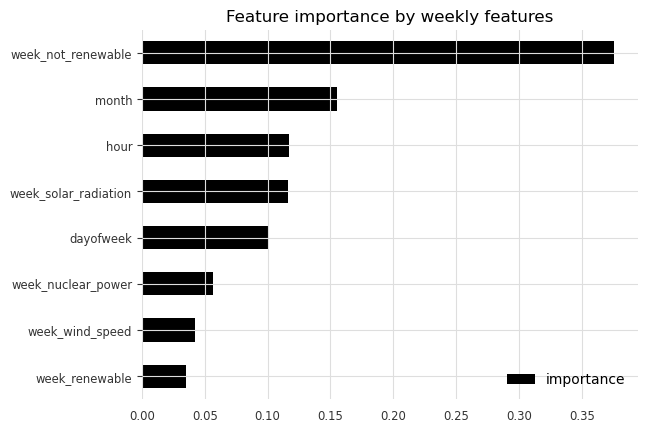

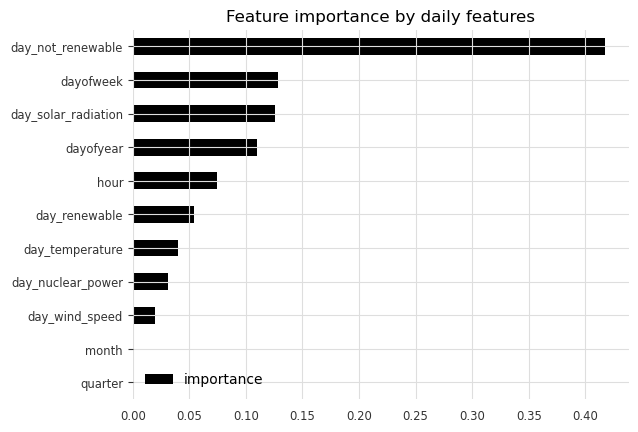

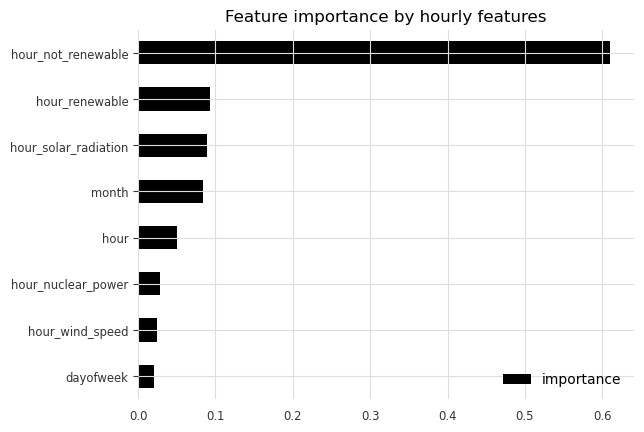

In [193]:
fi_week = pd.DataFrame(data=reg_week.feature_importances_,
            index=reg_week.feature_names_in_,
            columns=['importance'])

fi_day = pd.DataFrame(data=reg_day.feature_importances_,
            index=reg_day.feature_names_in_,
            columns=['importance'])

fi_hour = pd.DataFrame(data=reg_hour.feature_importances_,
            index=reg_hour.feature_names_in_,
            columns=['importance'])

fi_week.sort_values('importance').plot(kind='barh', title='Feature importance by weekly features')
fi_day.sort_values('importance').plot(kind='barh', title='Feature importance by daily features')
fi_hour.sort_values('importance').plot(kind='barh', title='Feature importance by hourly features')

### 8. Training model on all data

- Retraining on all given data except weekly and daily as the mape was not good and taking out the least important features

In [209]:
df = create_features(df)

#using all the data we have to create features 
FEATURES = ['month', 'dayofweek', 'hour', 
            'hour_solar_radiation', 
            #'hour_wind_speed', 
            #'hour_temperature', 
            'hour_not_renewable', 
            'hour_renewable', 
            'hour_nuclear_power', 
            #'day_temperature', 
            'day_solar_radiation', 
            #'day_wind_speed',
            'day_not_renewable', 
            'day_renewable', 
            'day_nuclear_power', 
            'week_solar_radiation', 
            #'week_temperature',
            #'week_wind_speed',
            'week_not_renewable', 
            'week_renewable', 
            'week_nuclear_power']

TARGET = ['energy_price']

# "splitting" the data into features and target data
X_all = df[FEATURES]
y_all = df[TARGET]

# creating the model
# base_score = default value, initial prediction score of the model
# booster = default value, type of boosting algorithm to use
# n_estimators = how many trees the model is going to build
# early_stopping_rounds = if model gets worse it will stop after 50 rounds
# objective = loss function to be optimized during training
# max_depth = maximum depth of each decision tree in the ensemble
#learning_rate = shrinkage factor applied to each update of the model during training
reg = xgb.XGBRegressor(base_score = 0.5, 
                        booster= 'gbtree',
                        n_estimators=500,  
                        objective = 'reg:linear',
                        max_depth = 3,
                        learning_rate=0.01)

#fitting the model
reg.fit(X_all, y_all,
        eval_set = [(X_all, y_all)],
        verbose=100
        )

# predicting 
y_pred = reg.predict(X_all)

# MAPE 
mape = mean_absolute_percentage_error(y_all, y_pred)

print("MAPE: {:.2f}%".format(mape * 100))


#ALL data week, day, hour
#299868582462780.50%

#ALL data ohne temp
#255337951030853.31%

#ALL data ohne temp + wind_speed
#253966097140080.41%

#ALL data ohne temp + wind_speed + solar
#267690005177139.00%

[22:28:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.38859
[100]	validation_0-rmse:15.27076
[200]	validation_0-rmse:9.44406
[300]	validation_0-rmse:7.58011
[400]	validation_0-rmse:6.84435
[499]	validation_0-rmse:6.43887
MAPE: 253966097140080.41%


- creating future dataframe and run through feature creation code + lag creation

In [210]:
#creating the hourly daterange for one week in the future of new year (2021)
future = pd.date_range('2020-12-31', '2021-01-08', freq='1h')
future_df = pd.DataFrame(index=future)

# adding True and False for isFuture to see easily inside the dataframe if the value is the future or not 
future_df['isFuture'] = True
df['isFuture'] = False

# adding the future and past covariates into our dataframe
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags_week(df_and_future)
df_and_future = add_lags_day(df_and_future)
df_and_future = add_lags_hour(df_and_future)

In [211]:
future_w_features = df_and_future.query('isFuture').copy()

### 9. Predicting the Future

- predicting the future with all the future and past covariates we created

In [212]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

- visualizing the predicted future

<AxesSubplot:title={'center':'Future Prediction'}>

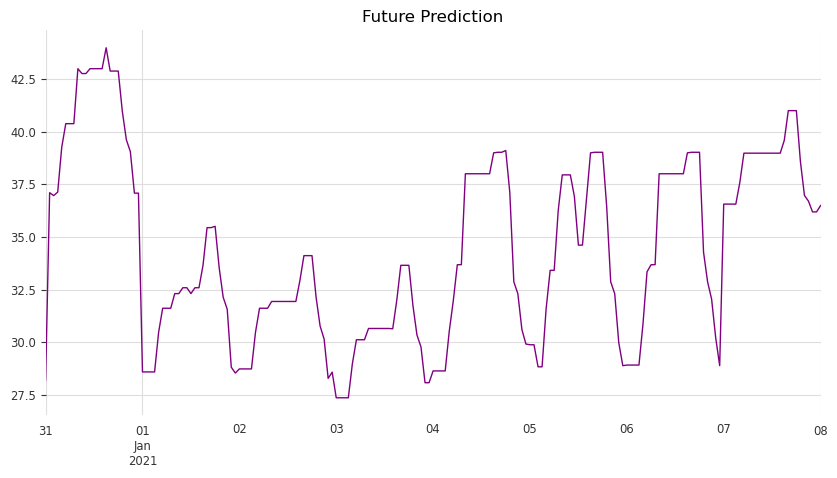

In [213]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color = 'purple',
                               ms = 1,
                               lw= 1,
                               title= 'Future Prediction')